# Locating Sound with Machine Learning

<br>

Most of the project code was actually built using Jupyter Notebooks, so the latest working code would be found in the `Notebooks` folder. Here the latest figures and hyperparameter tuning can be found. Demonstrations of the Neural Net, Support Vector Machine, and Random Forest are here.

The code is run via the command `python run.py test`. This runs the baseline model on the test data, which is simply the normal data but randomized.

Project code with working models can be found in `src` folder. Here the code for data generation and the test data can be found. This is also where the model code can be found which is in the `prediction` folder. Here, the code for the feed-forward Neural Net and the SVM can be found.

To build the `docker build -t <tag_name> .` which gives a local docker container with the libraries scipy, numpy, pandas, pytorch, and sklearn.

# Report Checkpoint

Brady Zhou, 
Raymond Zhao, 
and Lingpeng Meng

### Introduction

With the growing ubiquity of microphones (due in large part to Alexa and Google Home), localizing sound sources is becoming a more relevant issue. The paper [1] discusses two strategies to solve this issue: affine mapping (or linear transformation) and principal component analysis (PCA). PCAs and affine mappings were conducted to determine and map the sound source. In addition to the previously mentioned methods, supervised machine learning was also mentioned (though not executed) as another possible method. 

This group proposes to develop a supervised machine learning method mentioned in the paper[1] and also aim to address some of the issues with the previous methods. This is namely the low robustness to missingness in PCAs and the need for good anchor points in affine mapping.


### Problem

A playing speaker is placed on a desk in a room. With a set of microphone arrays placed around the room, its location can be roughly triangulated given the resulting data collected by the arrays, processed using beamforming [1]. In our experiment, our 5 arrays each produce a 3D "vector" of arrival that tells the direction from which the array perceived the signal. From here, the goal becomes to transform this data from $\mathbb{R}^{15}$ to $\mathbb{R}^{3}$

There are several naive solutions here, but two stand out as particularly robust: PCA and linear mapping. PCA seems a natural fit; downsizing from $15 \to 3$ with no real interpretative significance on any particular variable. While surprisingly precise, PCA suffers from 2 large issues: PCA can't handle missing values and the arrays' data output can be inconsistent, and the final result is couched in the fitted PCA space, which is extremely difficult to map back to the real world.

Linear (or affine) mappings solve the issues of missing values and abstract spaces but still leave a little to be desired, since accuracy is then limited by the fact that it still only maps linear functions when clearly the underlying dynamics of a room are likely nonlinear. This in addition to the fact that they need to be very well calibrating on anchor points to work some things to be desired, so the aim then is to find models to address the problems above while minimizing tradeoffs in accuracy or practicality.

### Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')
from Mapping import *
sys.path.append('../src/prediction')
from PCA import *
from nn import *

import pickle
import matplotlib
import matplotlib.pyplot as plt

In [2]:
V5 = pickle.load(open('../data/V5.p','rb'))
cp_list = V5["cp_list"]
active_L_table_slide_DOA = V5["active_L_table_slide_DOA"]
active_L_table_slide_matrix = V5["active_L_table_slide_matrix"]
active_long_table_slide_DOA = V5["active_long_table_slide_DOA"]
active_long_table_slide_matrix = V5["active_long_table_slide_matrix"]

In [3]:
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES
TABLE_CP_IND = [0,1,2,3,4,5]
CHAIR_CP_IND = [6,7,8,9,10]
ALL_CP_IND   = [0,1,2,3,4,5,6,7,8,9,10]
L_TABLE_CP_IND = [0,1,2,3]
LONG_TABLE_CP_IND = [4,5]
DATA_IND = [TABLE_CP_IND,CHAIR_CP_IND,ALL_CP_IND]

R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)

# use cp6 to calculate displacement for long table slide
R_6 = ROOM_COORDINATES[5,:2].T.reshape(-1,1)
D_6 = np.median(DOA_LIST[5], axis=0).reshape(-1,1)

R_LIST = [R_1, R_6]
D_LIST = [D_1, D_6]

### Plots
Here are example plots of all three networks in action. The following plots show the path that the sound source travels. The path makes a semi-rectangular path as it moves from each corner of the table on the lower portion of the l-shaped table. On the long table, the sound soruce travels in a relatively straight line. What paths we are expected is a rectangle on the right and a line on the left. 

#### Affine Mapping Plot (the baseline)
The baseline method for mapping sound source is an affine mapping [1]. Explained more deeply in the paper “Audio scene monitoring using redundant ad-hoc microphone array networks“, affine mapping is essentially a linear transformation of the values in the DoA matrix into real-world coordinates. The paths generated by these calculations are what we want to represent in our machine learning models.


([<matplotlib.axis.YTick at 0x229b4f78518>,
 <a list of 5 Text yticklabel objects>)

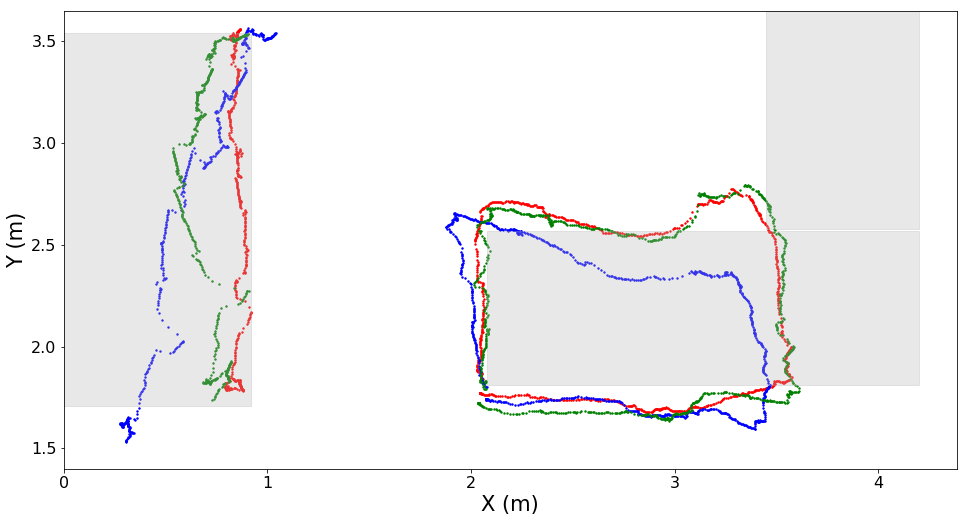

In [4]:
EVENT_DOA = [active_L_table_slide_DOA, active_long_table_slide_DOA]
EVENT_LABEL = ['L Table Slide', 'Long Table slide']
B_MATRIX_NAME = ['Table','Chair','All']
COLOR_LIST = ['r','b','g']
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]

fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

for ii in range(len(EVENT_DOA)):
    for jj in range(len(DATA_IND)):
        DOA_points = [DOA_LIST[IND] for IND in DATA_IND[jj]]
        room_coordinates = ROOM_COORDINATES[DATA_IND[jj],:]
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, room_coordinates, 2) 
        R_0 = R_LIST[ii]-B @ D_LIST[ii]
        r = R_0 +B @ EVENT_DOA[ii].T
        # only plot with label once
        if ii==0:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2) 
        else:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2, label=B_MATRIX_NAME[jj])    
ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  
# ax.scatter(ROOM_COORDINATES[:,0],ROOM_COORDINATES[:,1], c='k', s=30)
# ax.tick_params(axis='y', labelsize = 21, width = 2, length = 8)
# ax.tick_params(axis='x',labelsize = 21, width = 2, length = 8)

# for kk in range(ROOM_COORDINATES.shape[0]):
#     ax.scatter(ROOM_COORDINATES[kk,0]+0.2, ROOM_COORDINATES[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
# ax.legend(markerscale=5,fontsize=15)
# plt.show()
# fig.savefig('Mappingtables.pdf', bbox_inches='tight', pad_inches=0)

##### Figure 1: Blue is with the chair training points, red is the table, and green is with all

#### Feedforward Neural Net
Neural Networks work best by processing large datasets in ways similar to a human mind, but in ways the brain does not work. In the case of localizing sound source, this comes with processing data inputs of 15x3 shaped sound arrays. The gist of the neural network structure is a list of inputs is multiplied by a list of weights (which are determined after training) and then goes through a net input function to aggregate the points. Finally the remaining data goes through an activation function which finally returns the output. This feedforward neural network is the classic neural network architecture. The input shape is 15x3 while the output (in this use-case) is a 2-D coordinate. The hidden size is 20 and the number of epochs is 2. 

In [5]:
cp_torch = [torch.from_numpy(cp) for cp in cp_list[:4]]
room_coords = [torch.from_numpy(np.array([i[0], i[1]])) for i in ROOM_COORDINATES[:4]]
X = cp_torch
y = room_coords

In [6]:
model = NeuralNet(input_size, hidden_size, output_size)
model = model.float()

model.train(X, y)
predictions = model.predict(active_L_table_slide_DOA)

l_predictions = model.predict(active_long_table_slide_DOA)

([<matplotlib.axis.YTick at 0x229b66478d0>,
 <a list of 5 Text yticklabel objects>)

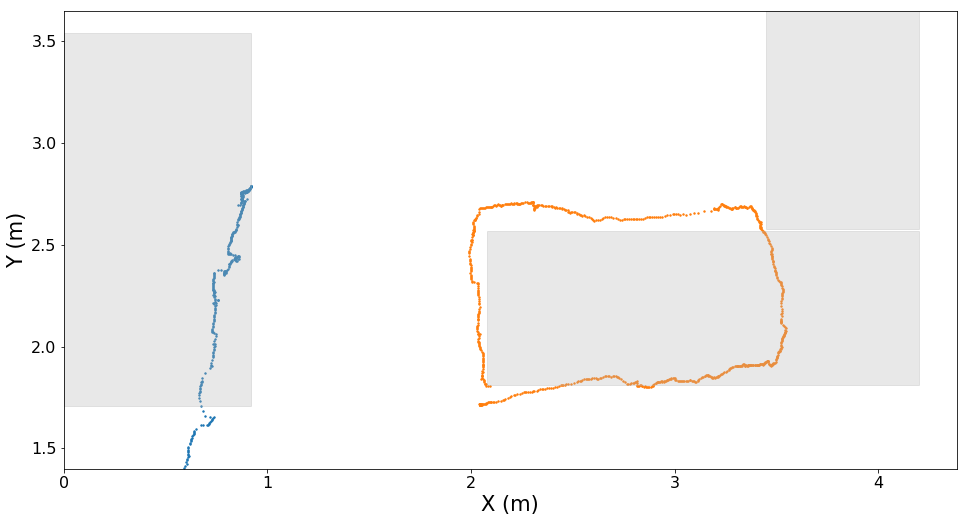

In [7]:
fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)

rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

# plot the path from the model
mapX = [x[0] for x in predictions]
mapy = [x[1] for x in predictions]
mapX_L = [x[0] for x in l_predictions]
mapy_L = [x[1] for x in l_predictions]

plt.scatter(mapX_L, mapy_L, s=2)
plt.scatter(mapX, mapy, s=2)

ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  

#### Support Vector Machine
SVM is a supervised learning algorithm that creates “decision boundaries” with regard to the values of the input data. While an SVM is known for being a classification algorithm, it is also capable of regression and can work with this sort of problem. We can see SVM works well at finding the general path of the sound; this can be attributed to SVM’s resilience with small training datasets. However, the model does not perform as well at finding sound that is far from the training points: the long-table sound data is very far off where it should be.

In [8]:
control_points = cp_list[:4]
coordinates = [np.array([i[0], i[1]]) for i in ROOM_COORDINATES[:4]]
X = np.vstack([c for c in cp_list[:4]])
y = np.vstack([np.full([p.shape[0], len(c)], c) for p, c in zip(control_points, coordinates)])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

regr = MultiOutputRegressor(SVR(kernel='rbf', C=1e3, gamma=0.1))
regr.fit(X, y)

MultiOutputRegressor(estimator=SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=None)

([<matplotlib.axis.YTick at 0x229be01f2e8>,
 <a list of 5 Text yticklabel objects>)

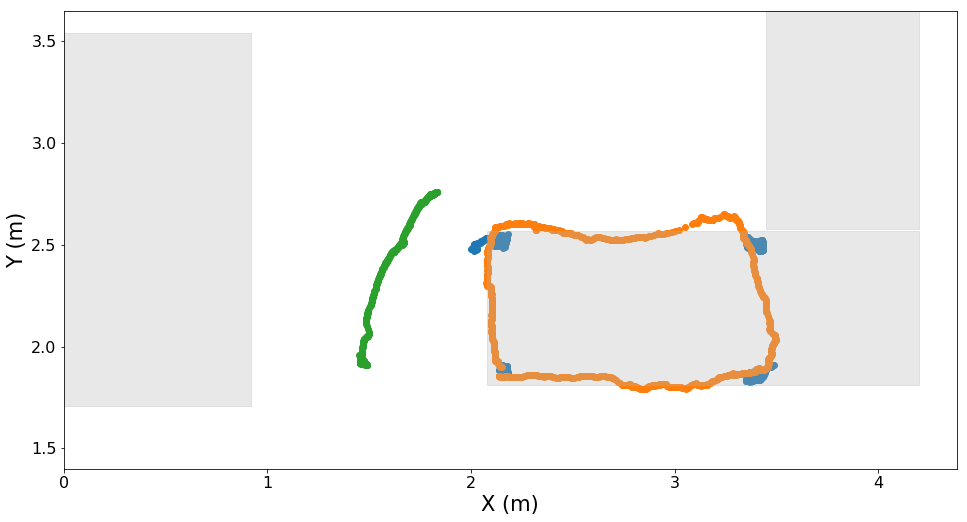

In [9]:
# plot the svm
fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)

rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

plt.scatter(*regr.predict(X).T)
plt.scatter(*regr.predict(active_L_table_slide_DOA).T)
plt.scatter(*regr.predict(active_long_table_slide_DOA).T)



ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  

#### Linear Regression compared with Random Forest and Decision Tree
Random Forest is another supervised learning algorithm that determines output values through a decision tree. Like decision trees, random forests are an ensemble method through a number of decisions. The difference between a random forest and a decision tree, however, is that random forest allows for significantly more granular decisions. Trees in general, though, have a tendency to overfit to their training datasets and - unlike the previous methods - produce irregular patterns, as we will see later.

('linear regression', <class 'sklearn.linear_model.base.LinearRegression'>)
('svr', <class 'sklearn.svm.classes.SVR'>)
('decision tree', <class 'sklearn.tree.tree.DecisionTreeRegressor'>)
('random forest', <class 'sklearn.ensemble.forest.RandomForestRegressor'>)


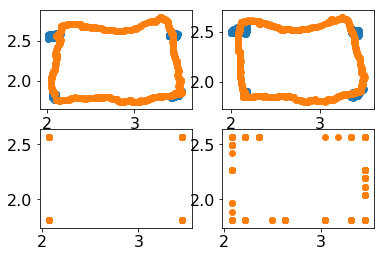

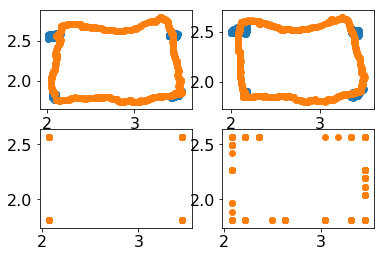

In [10]:
control_points = cp_list[:4]
coordinates = [np.array([i[0], i[1]]) for i in ROOM_COORDINATES[:4]]
X = np.vstack([c for c in cp_list[:4]])
y = np.vstack([np.full([p.shape[0], len(c)], c) for p, c in zip(control_points, coordinates)])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
models = {
    'linear regression': LinearRegression,
    'svr': SVR,
    'decision tree': DecisionTreeRegressor,
    'random forest': RandomForestRegressor
}
for m, ax in zip(models.items(), axes):
    print(m)
    model_name, model = m
    regr = MultiOutputRegressor(model())
    regr.fit(X, y)
    ax.scatter(*regr.predict(X).T)
    ax.scatter(*regr.predict(active_L_table_slide_DOA).T, label=model_name)
fig

The top plot is the decision tree comparison with linear regression and the bottom plot is the random forest compared with linear regression. Here we can see that both random forest and decision tree - as ensemble methods - share a weakness when the training data is as scant as we have here. Because of this, the model seems unable to find more than 18 points of locations for the sound.

#### Random Forest Plot on its own
Here we can see both the Random Forest's limitations by the data it is fed. As with our previous models, this random forest regressor was trained on the training points from the toy dataset. Because the training data really only consists of 4 points on the L-shaped table, the model has trouble with sound data orginating from elsewhere in the room. Here the model is also plotting data from the long table which is labeled with green, and we can clearly see it incorrectly places the sound on the l-shaped table.

([<matplotlib.axis.YTick at 0x229be007898>,
 <a list of 5 Text yticklabel objects>)

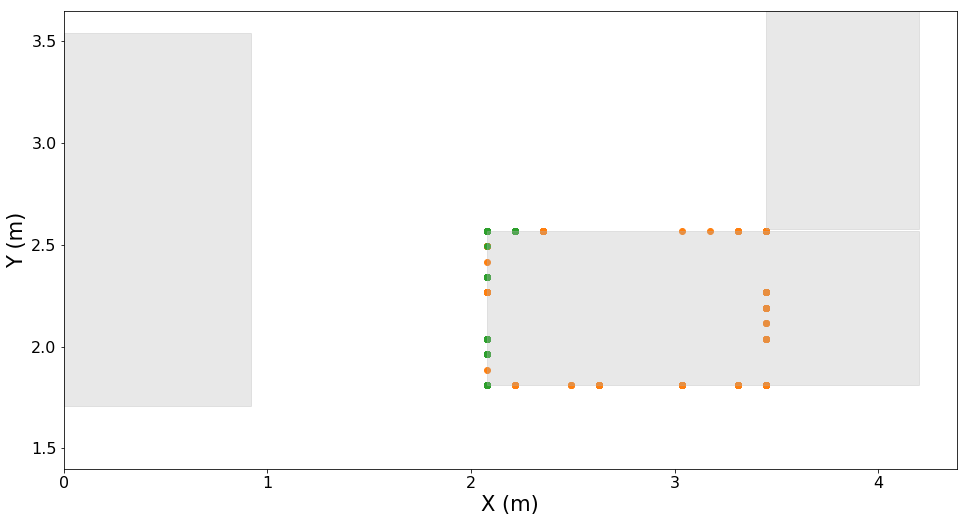

In [11]:
fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)

rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

plt.scatter(*regr.predict(X).T)
plt.scatter(*regr.predict(active_L_table_slide_DOA).T)
plt.scatter(*regr.predict(active_long_table_slide_DOA).T)


ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  

# Data Collection

### References

[1] P. Gerstoft, Y. Hu, M. J. Bianco, C. Patil, A. Alegre, Y. Freund, F. Grondin “Audio scene monitoring using redundant ad-hoc microphone array networks”

[2] M. Hahmann, E. Fernandez-Grande, H. Gunawan, P. Gerstoft “Sound Source Localization in 3D Using Ad-Hoc Distributed Microphone Arrays”

[3] B. Zhou, R. Zhao, L. Meng "Interpreting Microphone Arrays with Machine Learning Methods"